One of the breakthroughs in Natural Language Processing is the usage of word embeddings. Rather than using the words themselves as features, neural network methods typically take dense, relatively low-dimensional vectors that model the meaning and usage of a word as input. Word embeddings were first popularized through the [Word2Vec](https://arxiv.org/abs/1301.3781) model, developed by Thomas Mikolov and colleagues at Google. Since then, scores of alternative approaches have been developed, such as [GloVe](https://nlp.stanford.edu/projects/glove/) and [FastText](https://fasttext.cc/) embeddings. In this notebook, I've explore word embeddings with the original Word2Vec approach, as implemented in the [Gensim](https://radimrehurek.com/gensim/) library.

You already used an "Embedding" layer in PyTorch, which was directly trained within the network. However, we now take a closer look at embeddings and especially focus on the more common libraries.

## Overview
- [Training word embeddings](#Training-word-embeddings)
- [Using word embeddings](#Using-word-embeddings)
- [Plotting embeddings](#Plotting-embeddings)
- [Clustering embeddings](#Clustering-embeddings)
- [Conclusion](#Conclusion)

First, we need to download the Corpus. Wikipedia is a good choice for training generic embeddings. Typically, you would download the full Wikipedia ([here](https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles.xml.bz2)), but since this is over 21GB, just use a [fragment of about 275MB](https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles1.xml-p1p41242.bz2) and store it in your `Data` directory. We are using the English Wikipedia here.

In [1]:
from gensim.corpora import WikiCorpus # don't forget to install gensim ...

wikifile = "Data/enwiki-latest-pages-articles1.xml-p1p41242.bz2"
corpusfile = "Data/corpus-en.txt"

def make_corpus(in_f, out_f):

    """Convert Wikipedia xml dump file to text corpus"""

    output = open(out_f, 'w', encoding="utf-8")
    wiki = WikiCorpus(in_f)

    i = 0
    for text in wiki.get_texts():
        output.write(bytes(' '.join(text), 'utf-8').decode('utf-8') + '\n')
        i = i + 1
        if (i % 5000 == 0):
            print('Processed ' + str(i) + ' articles')
    output.close()
    print('Processing of '+ str(i) +' articles complete!')


#if __name__ == '__main__':
#    make_corpus("data/Wikipedia/enwiki-latest-pages-articles1.xml-p1p41242.bz2", "data/corpus-en.txt")
make_corpus(wikifile, corpusfile)

Processed 5000 articles
Processed 10000 articles
Processed 15000 articles
Processed 20000 articles
Processing of 20683 articles complete!


Have a look at the result in the `corpus-en.txt` file.

## Training word embeddings

Training word embeddings with Gensim couldn't be easier. The only thing we need is a corpus of sentences in the language under investigation (here German). This means we can feed lists of sentence tokens to Word2Vec by reading the lines in our Wikipedia file and splitting them on spaces (the data has been preprocessed using the WikiCorpus() above).

In [2]:
class SentenceCorpus(object):

    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        with open(self.filename, "r", encoding="utf-8") as i:
            for line in i:
                tokens = line.strip().split()
                yield tokens
               
sentences = SentenceCorpus(corpusfile)

When we train our word embeddings, gensim allows us to set a number of parameters. The most important of these are `min_count`, `window`, `size` and `sg`:

- `min_count` is the minimum frequency of the words in our corpus. For infrequent words, we just don't have enough information to train reliable word embeddings. It therefore makes sense to set this minimum frequency to at least 10. In these experiments, we'll set it to 100 to limit the size of our model even more.
- `window` is number of words to the left and to the right that make up the context that word2vec will take into account.
- `vector_size` is the dimensionality of the word vectors. This is generally between 100 and 1000. You often have to make a trade-off: embeddings with a higher dimensionality are able to model more information, but also need more data to train.
- `sg`: there are two algorithms to train word2vec: skip-gram and CBOW. Skip-gram tries to predict the context on the basis of the target word; CBOW tries to find the target on the basis of the context. By default, Gensim uses CBOW (`sg=0`).

We'll investigate the impact of some of these parameters later.

In [3]:
import gensim

model = gensim.models.Word2Vec(sentences, min_count=100, window=5, vector_size=100, sg=0)

## Using word embeddings

Let's take a look at the model. The word embeddings are on its wordvector (`wv`) attribute, and we can access them by the using the token as key. For example, here is the embedding for German *king*, with the requested 100 dimensions.

In [4]:
model.wv["king"]

array([-0.20634407, -3.2611907 ,  2.1082127 , -3.5211468 ,  0.1754411 ,
       -1.742285  , -0.8111585 ,  1.6651087 , -3.1816535 , -1.3627368 ,
       -2.77862   , -3.7005978 ,  0.9057486 , -0.45199996, -0.04109674,
        0.6904301 ,  1.9798598 , -0.32047483, -1.4192293 ,  1.5785745 ,
       -0.31404644,  0.70612866, -3.10965   ,  1.5634166 ,  0.8669865 ,
       -1.9428263 , -1.853199  ,  0.088844  , -1.620298  , -0.26399115,
        2.7886608 ,  0.74784017,  1.456875  ,  0.5705539 ,  0.8791558 ,
        2.5381496 ,  1.6772367 ,  0.26790485,  0.66981804, -1.229718  ,
       -2.7162704 ,  1.624305  ,  0.46504024, -0.18251422, -0.6167242 ,
        0.18347715, -0.8338688 ,  4.2017283 ,  2.9226453 , -0.5643983 ,
       -1.2138618 ,  1.877376  , -1.1245645 , -0.09753057, -1.1021608 ,
        1.1711714 ,  0.91671646, -1.9158128 ,  1.9772563 ,  0.71959764,
       -0.95270973,  0.20191573, -1.9576625 ,  1.1555995 ,  2.468587  ,
        1.7026349 ,  0.93938607,  1.1150419 , -0.70521456, -0.55

We can also easily find the similarity between two words. Similarity is measured as the **cosine** between the two word embeddings, and ranges between -1 and +1. The higher the cosine, the more similar two words are. As expected, the figures below show that *king* is closer to *queen* than to *champion*.

In [5]:
print(model.wv.similarity("king", "queen"))
print(model.wv.similarity("king", "champion"))

0.7039701
0.23728082


In a similar vein, we can find the words that are most similar to a target word. The words with the most similar embedding to *king* are all similar titles (such as *emperor* or *prince*) or are names of kings (*valdemar*).

In [6]:
model.wv.similar_by_word("king", topn=10)

[('prince', 0.7660161852836609),
 ('regent', 0.7209688425064087),
 ('pretender', 0.715506911277771),
 ('queen', 0.7039700746536255),
 ('ruler', 0.7022864818572998),
 ('valdemar', 0.7005651593208313),
 ('æthelred', 0.69357830286026),
 ('emperor', 0.6928158402442932),
 ('ladislaus', 0.6921259164810181),
 ('kings', 0.6898197531700134)]

Interestingly, we can look for words that are similar to a set of words and dissimilar to another set of words at the same time. This allows us to look for analogies of the type *king* is to *man* like ... is to *woman*. 
This example gives *queen* as the top result - as it should be. However, there are other promising candidates, as you can see. If you want, you can try out a few more examples by yourself -- but please remember that our training data is very small and results may vary.

In [7]:
model.wv.most_similar(positive=['king', 'woman'], negative=["man"], topn=10)

[('queen', 0.7386533617973328),
 ('regent', 0.7063547372817993),
 ('consort', 0.6697030663490295),
 ('empress', 0.6683894395828247),
 ('jadwiga', 0.6430900692939758),
 ('princess', 0.6348363757133484),
 ('prince', 0.6332730054855347),
 ('regnant', 0.6251538395881653),
 ('valois', 0.6100114583969116),
 ('vasa', 0.6033540964126587)]

Similarly, we can also zoom in on one of the meanings of ambiguous words. For example, the term, *tie* in English can refer to many things: an undecided match, something to wear, or the verb meaning "to join" (for further examples, see, e.g., [here](https://www.yourdictionary.com/articles/words-multiple-meanings))

In [8]:
model.wv.most_similar(positive=["tie"], topn=20)

[('showdown', 0.5401918888092041),
 ('bowling', 0.5401571393013),
 ('clinch', 0.5374212861061096),
 ('knockout', 0.5255204439163208),
 ('pick', 0.5222055315971375),
 ('rematch', 0.5207799673080444),
 ('finish', 0.5196738839149475),
 ('tying', 0.5088011622428894),
 ('glove', 0.5068738460540771),
 ('break', 0.5018192529678345),
 ('throw', 0.501250684261322),
 ('flush', 0.498345285654068),
 ('opener', 0.49658700823783875),
 ('win', 0.4923076927661896),
 ('picks', 0.49209412932395935),
 ('toss', 0.48947516083717346),
 ('socks', 0.488945871591568),
 ('streak', 0.4864085018634796),
 ('bengals', 0.48610103130340576),
 ('hingis', 0.4849415421485901)]

However, if we specify we're looking for words that are similar to *tie* , but dissimilar to *win*, suddenly the best matches are almost all related to dressing up.

In [9]:
model.wv.most_similar(positive=["tie"], negative=["win"], topn=10)

[('plastic', 0.45154833793640137),
 ('drills', 0.4362519681453705),
 ('glue', 0.42759212851524353),
 ('bag', 0.4258405566215515),
 ('molded', 0.42002561688423157),
 ('shiny', 0.4121289849281311),
 ('framing', 0.4025627076625824),
 ('jacket', 0.4020610749721527),
 ('ribbons', 0.4012385904788971),
 ('foam', 0.39725103974342346)]

Finally, we can present the word2vec model with a list of words and ask it to identify the odd one out. It then uses the word embeddings to identify the word that is least similar to the other ones. For example, in the list *seminar university king study*, it correctly identifies *king* as the odd one out.

In [10]:
print(model.wv.doesnt_match("seminar university king study".split()))

king


## Plotting embeddings

Let's now visualize some of our embeddings. To plot embeddings with a dimensionality of 100 or more, we first need to map them to a dimensionality of 2. We do this by using **Principal Component Analysis (PCA)** [(more info)](https://en.wikipedia.org/wiki/Principal_component_analysis). T-SNE, short for t-distributed Stochastic Neighbor Embedding, helps us visualize high-dimensional data by mapping similar data to nearby points and dissimilar data to distance points in the low-dimensional space.

T-SNE is present in [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). To run it, we just have to specify the number of dimensions we'd like to map the data to (`n_components`), and the similarity metric that t-SNE should use to compute the similarity between two data points (`metric`). We're going to map to 2 dimensions and use the cosine as our similarity metric. Additionally, we use PCA as an initialization method to remove some noise and speed up computation. The [Scikit-learn user guide](https://scikit-learn.org/stable/modules/manifold.html#t-sne) contains some additional tips for optimizing performance. 

Plotting all the embeddings in our vector space would result in a very crowded figure where the labels are hardly legible. Therefore, we'll focus on a subset of embeddings by selecting the 200 most similar words to a target word.

In [12]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

target_word = "king"
selected_words = [w[0] for w in model.wv.most_similar(positive=[target_word], topn=200)]
embeddings = np.array([model.wv[w] for w in selected_words])

mapped_embeddings = TSNE(
    n_components=2,
    metric='cosine',
    init='pca',
    learning_rate='auto'
).fit_transform(embeddings)

If we take *king* as our target word, the figure shows some interesting patterns. Notice how 
* roman numerals are clustered together
* on the top right, we have a "north-eastern" connotation
* on the bottom right, we have terms for noblemen

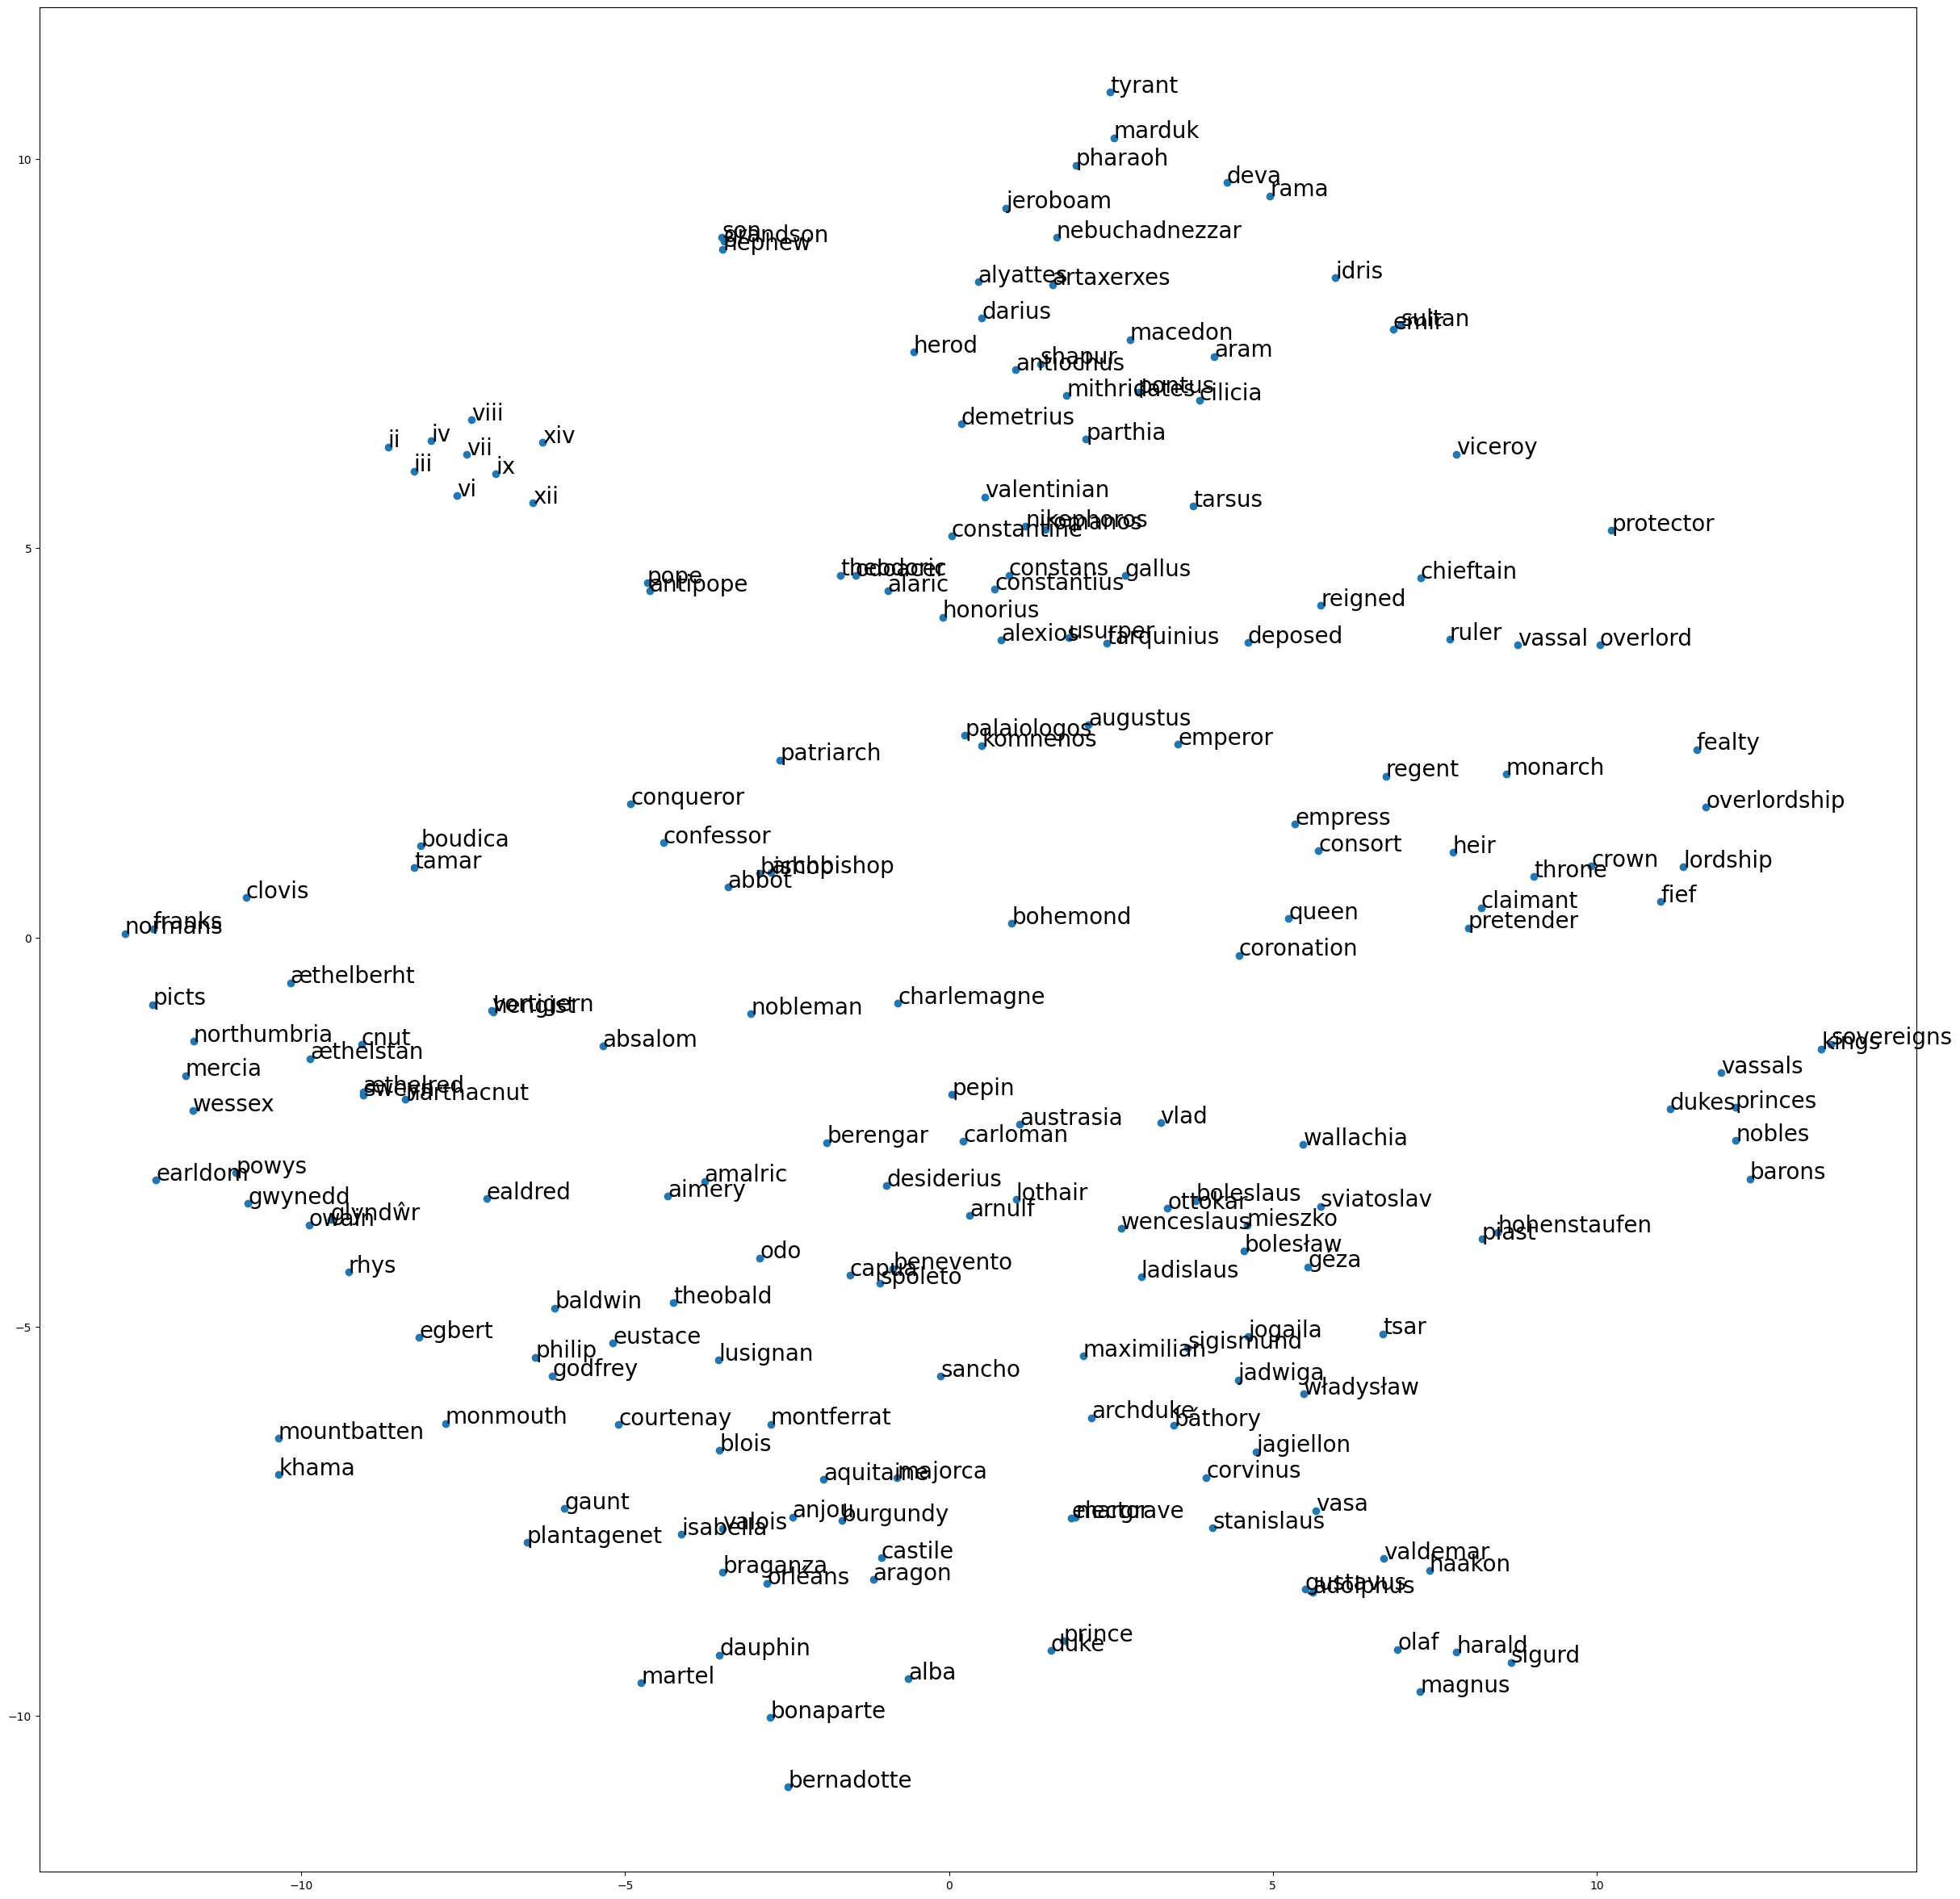

In [13]:
plt.figure(figsize=(30,30))
x = mapped_embeddings[:,0]
y = mapped_embeddings[:,1]
plt.scatter(x, y)

for i, txt in enumerate(selected_words):
    plt.annotate(txt, (x[i], y[i]), size=20)

## Clustering embeddings

Finally, we're going to cluster our embeddings. This can be useful to model semantic information. We'll use agglomerative clustering, a bottom-up clustering method that iteratively takes together the two most similar clusters (or embeddings) in the data.

In [14]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize

vocab = list(model.wv.key_to_index)
vectors = [model.wv[w] for w in vocab]
vectors_norm = normalize(vectors)

clusterer = AgglomerativeClustering(n_clusters=500)
clusters = clusterer.fit_predict(vectors_norm)

Let's inspect some of the clusters. By focusing on some of the clusters that contain the names of countries, we can see how these clusters can be useful.

In [15]:
cluster_dictionary = {}
for cluster, word in zip(clusters, vocab): 
    if cluster not in cluster_dictionary:
        cluster_dictionary[cluster] = []
    cluster_dictionary[cluster].append(word)

In [16]:
for x in cluster_dictionary:
    if "korea" in cluster_dictionary[x]:
        print(cluster_dictionary[x])
print("\nAnother cluster:")
for x in cluster_dictionary:
    if "germany" in cluster_dictionary[x]:
        print(cluster_dictionary[x])

['chinese', 'japanese', 'indian', 'korea', 'arab', 'islamic', 'vietnam', 'korean', 'persian', 'turkish', 'egyptian', 'sri', 'iranian', 'armenian', 'vietnamese', 'thai', 'lanka', 'syrian', 'indonesian', 'afghan', 'albanian', 'iraqi', 'tamil', 'pakistani', 'lebanese', 'georgian', 'philippine', 'ethiopian', 'moroccan', 'malaysian', 'burmese', 'somali', 'taiwanese', 'libyan', 'lankan', 'kurdish', 'mongolian', 'sudanese', 'algerian', 'lao', 'cambodian', 'azerbaijani', 'kazakh', 'jordanian', 'uzbek', 'nadu', 'cypriot', 'bangladeshi', 'nepali', 'yemeni', 'pashtun', 'tajik', 'tunisian', 'viet', 'kyrgyz', 'singaporean', 'eritrean', 'turkmen', 'sinhalese', 'kuwaiti', 'pla', 'hazara', 'cong', 'qatari', 'malayan', 'omani', 'nepalese', 'hmong', 'cham', 'maldivian', 'tamils', 'bahraini']

Another cluster:
['germany', 'russia', 'poland', 'sweden', 'netherlands', 'austria', 'hungary', 'finland', 'denmark', 'norway', 'ukraine', 'romania', 'switzerland', 'belgium', 'lithuania', 'croatia', 'serbia', 'arm

## Conclusion

Word embeddings are one of the most exciting trends on Natural Language Processing since the 2000s. They allow us to model the meaning and usage of a word, and discover words that behave similarly. This is crucial for the generalization capacity of many machine learning models. Moving from raw strings to embeddings allows them to generalize across words that have a similar meaning, and discover patterns that had previously escaped them.